<a href="https://colab.research.google.com/github/ayaka1802/corab-1.github.io/blob/main/Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab/Trial

/content/drive/MyDrive/Colab/Trial


In [ ]:
%run prepare_images.py datasets/flower2

Copied images from datasets/flower2/Erysimumcheiri
Copied images from datasets/flower2/Plumeria
Copied images from datasets/flower2/Cyclamen
Copied images from datasets/flower2/Hasu
Copied images from datasets/flower2/Passiflora
Copied images from datasets/flower2/Kinrenka


In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import visualize
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow

print(tf.__version__)


train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

backup_dir = './model'

labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

TensorFlow 1.x selected.
1.15.2
class number=6
['Cyclamen', 'Erysimumcheiri', 'Hasu', 'Kinrenka', 'Passiflora', 'Plumeria']


Found 908 images belonging to 6 classes.
Found 231 images belonging to 6 classes.
## Train Data Sample ##


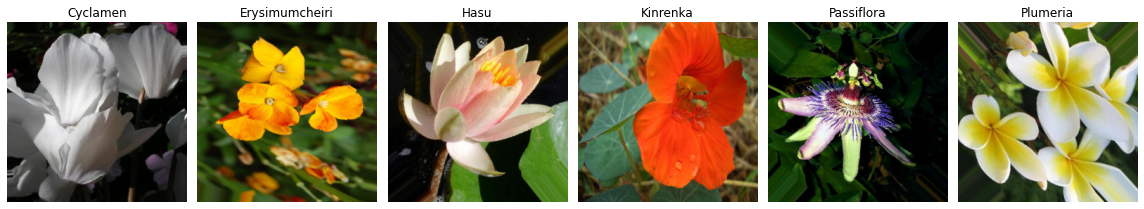

In [ ]:
# 学習率
LEARNING_RATE = 0.0001
# エポック（世代数）
EPOCHS =35
# バッチサイズ
BATCH_SIZE = 16

IMAGE_SIZE = 256

#train_data_gen = ImageDataGenerator(rescale=1./255)
train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=180)
#train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=180, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255)

# メモ：ImageDataGenerator.flow_from_directory はIteratorを返す
train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Display train data sample
visualize.pick_train_sample(labels, train_data)

In [ ]:
#vgg16をインポートして、クラスをインスタンス化する
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
#vgg16modelの詳細を表示
#Trainable params: 0に注目
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
#vgg16modelのconv_baseの'block5_conv1'以降の3段をtrainable = Trueに設定する
#それ以前の段はtrainable = Falseに設定する
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
#vgg16modelの詳細を表示
#Trainable params: 7,079,424に注目
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
#vgg16modelに続けて全結合層を追加
last = conv_base.output

mod = Flatten()(last)
mod = Dense(256, activation='relu')(mod)
mod = Dropout(0.5)(mod)
preds = Dense(6, activation='softmax')(mod)

model = keras.Model(inputs=conv_base.input, outputs=preds, name="test_model")
#model = models.Model(conv_base.input, preds)
model.summary()

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0

In [ ]:
#model compile

#opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)
opt = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0

In [ ]:
#エポック終了毎にモデルsaveするcallbackを作成

checkpoint_path = "model_save_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
#学習を実施

#history = dense_model.fit(train_data, steps_per_epoch=10, epochs=EPOCHS, validation_data, verbose=1)
history = model.fit(train_data, epochs=EPOCHS, callbacks=[cp_callback], validation_data=validation_data, verbose=1)


Epoch 1/35
15/57 [======>.......................] - ETA: 13s - loss: 0.1947 - acc: 0.9221
Epoch 00001: saving model to model_save_1/cp-0001.ckpt
57/57 [==============================] - 35s 620ms/step - loss: 1.0479 - acc: 0.6366 - val_loss: 0.1947 - val_acc: 0.9221
Epoch 2/35
15/57 [======>.......................] - ETA: 9s - loss: 0.1312 - acc: 0.9610 
Epoch 00002: saving model to model_save_1/cp-0002.ckpt
57/57 [==============================] - 26s 458ms/step - loss: 0.2902 - acc: 0.9031 - val_loss: 0.1312 - val_acc: 0.9610
Epoch 3/35
15/57 [======>.......................] - ETA: 9s - loss: 0.1574 - acc: 0.9394
Epoch 00003: saving model to model_save_1/cp-0003.ckpt
57/57 [==============================] - 27s 472ms/step - loss: 0.1109 - acc: 0.9670 - val_loss: 0.1574 - val_acc: 0.9394
Epoch 4/35
15/57 [======>.......................] - ETA: 9s - loss: 0.0387 - acc: 0.9913
Epoch 00004: saving model to model_save_1/cp-0004.ckpt
57/57 [==============================] - 28s 484ms/step 

In [ ]:
#modelを再度コンパイルしてから、val_lossの一番低いsaveデータをロードする

checkpoint_path = "model_save_1/cp-0006.ckpt"

model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

model.load_weights(checkpoint_path)

In [ ]:
#saveデータから復活したmodelで評価を実施する

score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15/15 [==============================] - 3s 211ms/step - loss: 0.0853 - acc: 0.9697
Test loss: 0.08534714913960974
Test accuracy: 0.969697


Prediction data
[[0.972 0.004 0.012 0.003 0.001 0.008]
 [0.677 0.304 0.004 0.007 0.001 0.007]
 [0.705 0.097 0.13  0.042 0.013 0.014]
 ...
 [0.008 0.001 0.013 0.001 0.003 0.974]
 [0.096 0.011 0.001 0.    0.001 0.891]
 [0.    0.    0.    0.    0.    1.   ]]
(231, 6)
#0 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00456.jpg
Each Prediction Value: [0.972 0.004 0.012 0.003 0.001 0.008]
* Correct *
#1 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00462.jpg
Each Prediction Value: [0.677 0.304 0.004 0.007 0.001 0.007]
* Correct *
#2 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00463.jpg
Each Prediction Value: [0.705 0.097 0.13  0.042 0.013 0.014]
* Correct *
#3 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00464.jpg
Each Prediction Value: [0.981 0.001 0.004 0.011 0.001 0.003]
* Correct *
#4 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00465.jpg
Each Prediction Value: [0.807 0.111 0.027 0.012 0.007 0.037]
* Correct *


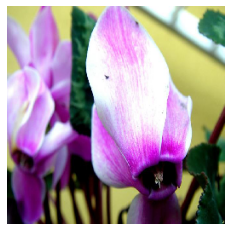

#27 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00549.jpg
Each Prediction Value: [0.846 0.114 0.005 0.007 0.002 0.025]
* Correct *
#28 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00575.jpg
Each Prediction Value: [0.813 0.14  0.006 0.02  0.004 0.016]
* Correct *
#29 Expected:Cyclamen -> Predicted:Cyclamen
File: Cyclamen/image_00595.jpg
Each Prediction Value: [0.878 0.119 0.    0.001 0.    0.002]
* Correct *
#30 Expected:Erysimumcheiri -> Predicted:Erysimumcheiri
File: Erysimumcheiri/image_00948.jpg
Each Prediction Value: [0.    0.999 0.    0.    0.    0.   ]
* Correct *
#31 Expected:Erysimumcheiri -> Predicted:Erysimumcheiri
File: Erysimumcheiri/image_00951.jpg
Each Prediction Value: [0.045 0.941 0.001 0.012 0.    0.001]
* Correct *
#32 Expected:Erysimumcheiri -> Predicted:Erysimumcheiri
File: Erysimumcheiri/image_00952.jpg
Each Prediction Value: [0. 1. 0. 0. 0. 0.]
* Correct *
#33 Expected:Erysimumcheiri -> Predicted:Erysimumcheiri
File: Erysimumcheiri

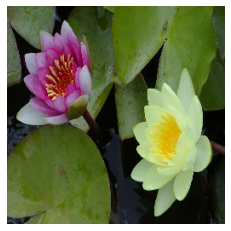

#106 Expected:Hasu -> Predicted:Hasu
File: Hasu/image_00440.jpg
Each Prediction Value: [0. 0. 1. 0. 0. 0.]
* Correct *
#107 Expected:Hasu -> Predicted:Hasu
File: Hasu/image_00441.jpg
Each Prediction Value: [0.    0.    0.999 0.    0.    0.   ]
* Correct *
#108 Expected:Hasu -> Predicted:Hasu
File: Hasu/image_00443.jpg
Each Prediction Value: [0. 0. 1. 0. 0. 0.]
* Correct *
#109 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00599.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#110 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00602.jpg
Each Prediction Value: [0.    0.031 0.    0.968 0.    0.   ]
* Correct *
#111 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00605.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#112 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00607.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#113 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00608.jpg
Each Pr

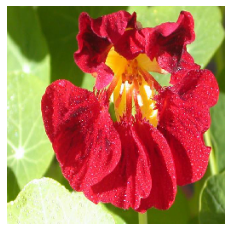

#141 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00758.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#142 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00759.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#143 Expected:Kinrenka -> Predicted:Erysimumcheiri
File: Kinrenka/image_00762.jpg
Each Prediction Value: [0.023 0.683 0.008 0.279 0.006 0.001]
**** INCORRECT ****


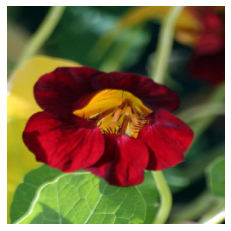

#144 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00764.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0.]
* Correct *
#145 Expected:Kinrenka -> Predicted:Kinrenka
File: Kinrenka/image_00766.jpg
Each Prediction Value: [0.    0.    0.    0.999 0.    0.   ]
* Correct *
#146 Expected:Passiflora -> Predicted:Passiflora
File: Passiflora/image_00002.jpg
Each Prediction Value: [0. 0. 0. 0. 1. 0.]
* Correct *
#147 Expected:Passiflora -> Predicted:Passiflora
File: Passiflora/image_00005.jpg
Each Prediction Value: [0. 0. 0. 0. 1. 0.]
* Correct *
#148 Expected:Passiflora -> Predicted:Passiflora
File: Passiflora/image_00010.jpg
Each Prediction Value: [0. 0. 0. 0. 1. 0.]
* Correct *
#149 Expected:Passiflora -> Predicted:Passiflora
File: Passiflora/image_00011.jpg
Each Prediction Value: [0. 0. 0. 0. 1. 0.]
* Correct *
#150 Expected:Passiflora -> Predicted:Passiflora
File: Passiflora/image_00015.jpg
Each Prediction Value: [0. 0. 0. 0. 1. 0.]
* Correct *
#151 Expected:Passiflora -> Predict

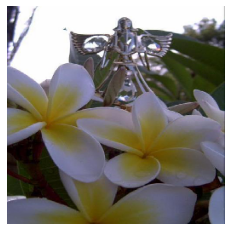

#215 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00867.jpg
Each Prediction Value: [0.189 0.006 0.013 0.008 0.012 0.77 ]
* Correct *
#216 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00868.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#217 Expected:Plumeria -> Predicted:Cyclamen
File: Plumeria/image_00884.jpg
Each Prediction Value: [0.658 0.047 0.021 0.021 0.006 0.248]
**** INCORRECT ****


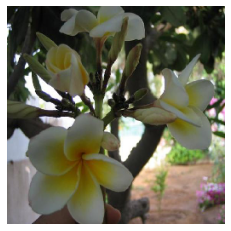

#218 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00890.jpg
Each Prediction Value: [0.229 0.018 0.01  0.022 0.01  0.711]
* Correct *
#219 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00892.jpg
Each Prediction Value: [0.    0.    0.    0.    0.    0.999]
* Correct *
#220 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00894.jpg
Each Prediction Value: [0.002 0.    0.    0.    0.    0.998]
* Correct *
#221 Expected:Plumeria -> Predicted:Cyclamen
File: Plumeria/image_00898.jpg
Each Prediction Value: [0.658 0.038 0.003 0.    0.001 0.299]
**** INCORRECT ****


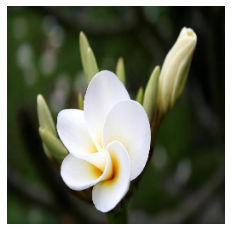

#222 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00899.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#223 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00914.jpg
Each Prediction Value: [0.008 0.    0.    0.    0.    0.992]
* Correct *
#224 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00919.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#225 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00924.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#226 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00926.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#227 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00932.jpg
Each Prediction Value: [0. 0. 0. 0. 0. 1.]
* Correct *
#228 Expected:Plumeria -> Predicted:Plumeria
File: Plumeria/image_00934.jpg
Each Prediction Value: [0.008 0.001 0.013 0.001 0.003 0.974]
* Correct *
#229 Expected:Plumeria -> Predicted:Plumeria
Fi

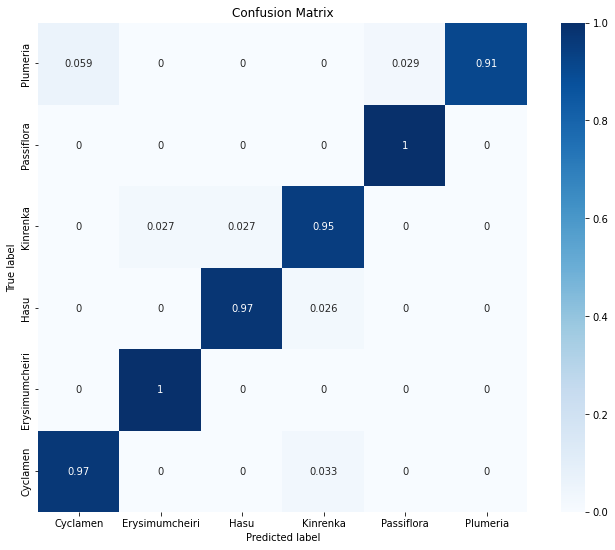

In [ ]:
# Failed pictures
visualize.vis_failed_pic(model, labels, validation_data, val_dir, BATCH_SIZE, 100)

# Visualize loss
#visualize.vis_loss_accuracy(history, EPOCHS)

# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# Confusion Matrix
visualize.vis_confusion_matrix(model, validation_data)

Text(0, 0.5, 'Accuracy & Loss')

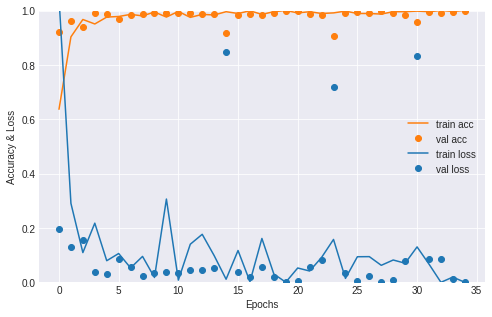

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,5))

epoch = history.epoch
train_acc = history.history["acc"]
train_loss = history.history["loss"]
val_acc = history.history["val_acc"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

In [ ]:
#visualize.vis_filter(model, 'conv2d')
#visualize.vis_filter(model, 'conv2d_1')

In [ ]:
#!cat incorrect.txt

In [ ]:
#visualize.vis_hidden_layer('incorrect.txt', 'activation_1', IMAGE_SIZE)